## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/predicting-disturbances-in-the-ionosphere/)) <font size='3ptx'>**It can be challenging to develop a neural network predictive model for a new dataset.**</font>

One approach is to first inspect the dataset and develop ideas for what models might work, then explore the learning dynamics of simple models on the dataset, then finally develop and tune a model for the dataset with a robust test harness.

This process can be used to develop effective neural network models for classification and regression predictive modeling problems.

**In this tutorial, you will discover how to develop a Multilayer Perceptron neural network model for the ionosphere binary classification dataset.** After completing this tutorial, you will know:
* How to load and summarize the ionosphere dataset and use the results to suggest data preparations and model configurations to use.
* How to explore the learning dynamics of simple MLP models on the dataset.
* How to develop robust estimates of model performance, tune model performance, and make predictions on new data.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into four parts; they are:
* <font size='3ptx'>[**Ionosphere Binary Classification Dataset**](#sect1)</font>
* <font size='3ptx'>[**Neural Network Learning Dynamics**](#sect2)</font>
* <font size='3ptx'>[**Evaluating and Tuning MLP Models**](#sect3)</font>
* <font size='3ptx'>[**Final Model and Make Predictions**](#sect4)</font>

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean, std
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Dropout

<a id='sect1'></a>
## <font color='darkblue'>Ionosphere Binary Classification Dataset</font>
**The first step is to define and explore the dataset.**

We will be working with the “Ionosphere” standard binary classification dataset. This dataset involves predicting whether a structure is in the atmosphere or not given radar returns. You can learn more about the dataset here:
* [Ionosphere Dataset (ionosphere.csv)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv)
* [Ionosphere Dataset Details (ionosphere.names)](https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.names)

You can see the first few rows of the dataset below.

In [4]:
# load the ionosphere dataset and summarize the shape
# define the location of the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/ionosphere.csv'

# load the dataset
df = pd.read_csv(url, header=None)

# summarize shape
df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [5]:
df.shape

(351, 35)

In this case, we can see that the dataset has 35 variables (<font color='brown'>34 input and one output</font>) and that the dataset has 351 rows of data.

This is not many rows of data for a neural network and suggests that a small network, perhaps with regularization, would be appropriate.

**It also suggests that using [k-fold cross-validation](https://machinelearningmastery.com/k-fold-cross-validation/) would be a good idea given that it will give a more reliable estimate of model performance than a train/test split and because a single model will fit in seconds** instead of hours or days with the largest datasets.

Next, we can learn more about the dataset by looking at summary statistics and a plot of the data.

In [6]:
# show summary statistics
print(df.describe())

               0      1           2           3           4           5   \
count  351.000000  351.0  351.000000  351.000000  351.000000  351.000000   
mean     0.891738    0.0    0.641342    0.044372    0.601068    0.115889   
std      0.311155    0.0    0.497708    0.441435    0.519862    0.460810   
min      0.000000    0.0   -1.000000   -1.000000   -1.000000   -1.000000   
25%      1.000000    0.0    0.472135   -0.064735    0.412660   -0.024795   
50%      1.000000    0.0    0.871110    0.016310    0.809200    0.022800   
75%      1.000000    0.0    1.000000    0.194185    1.000000    0.334655   
max      1.000000    0.0    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9   ...          24  \
count  351.000000  351.000000  351.000000  351.000000  ...  351.000000   
mean     0.550095    0.119360    0.511848    0.181345  ...    0.396135   
std      0.492654    0.520750    0.507066    0.483851  ...    0.578451   
min     -1.000000  

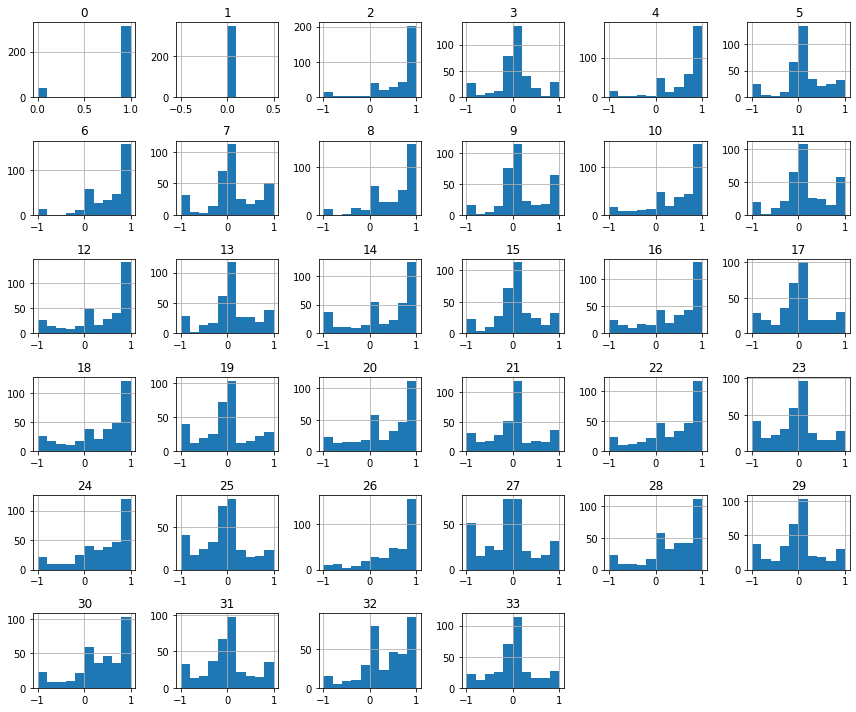

In [14]:
# plot histograms
#plt.rcParams['figure.figsize'] = [12, 10]
df.hist()
plt.tight_layout()

We can see that many variables have a Gaussian or Gaussian-like distribution.

We may have some benefit in using a [**power transform**](https://machinelearningmastery.com/power-transforms-with-scikit-learn/) on each variable in order to make the probability distribution less skewed which will likely improve model performance.

Now that we are familiar with the dataset, let’s explore how we might develop a neural network model.

<a id='sect2'></a>
## <font color='darkblue'>Neural Network Learning Dynamics</font>
**We will develop a Multilayer Perceptron (MLP) model for the dataset using TensorFlow.**

**We cannot know what model architecture of learning hyperparameters would be good or best for this dataset, so we must experiment and discover what works well.** Given that the dataset is small, a small [batch size](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/) is probably a good idea, e.g. 16 or 32 rows. Using the Adam version of stochastic gradient descent is a good idea when getting started as it will automatically adapts the [learning rate](https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/) and works well on most datasets.

Before we evaluate models in earnest, it is a good idea to review the learning dynamics and tune the model architecture and learning configuration until we have stable learning dynamics, then look at getting the most out of the model.

We can do this by using a simple [train/test split](https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/) of the data and review plots of the [learning curves](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/). This will help us see if we are over-learning or under-learning; then we can adapt the configuration accordingly.

First, we must ensure all input variables are floating-point values and encode the target label as integer values 0 and 1.

In [47]:
# split into input and output columns
X, y = df.values[:, :-1], df.values[:, -1]

In [91]:
# ensure all data are floating point values
X = np.asarray(X).astype('float32')

# encode strings to integer
le = LabelEncoder()
y = le.fit_transform(y)

Next, we can split the dataset into input and output variables, then into 67/33 train and test sets.

In [49]:
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

We can define a minimal MLP model. In this case, we will use one hidden layer with 10 nodes and one output layer (<font color='brown'>chosen arbitrarily</font>). We will use the [ReLU activation function](https://machinelearningmastery.com/how-to-fix-vanishing-gradients-using-the-rectified-linear-activation-function/) in the hidden layer and the “he_normal” weight initialization, as together, they are a good practice.

The output of the model is a sigmoid activation for binary classification and we will minimize [binary cross-entropy loss](https://machinelearningmastery.com/cross-entropy-for-machine-learning/).

In [50]:
def get_mlp_model(n_features):    
    # define model
    model = Sequential()
    model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

In [51]:
model = get_mlp_model(X_train.shape[1])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 10)                350       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


We will fit the model for **200 training epochs** (<font color='brown'>chosen arbitrarily</font>) with a **batch size of 32** because it is a small dataset. We are fitting the model on raw data, which we think might be a good idea, but it is an important starting point.

In [52]:
# fit the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=200,
    batch_size=32,
    verbose=0,
    validation_data=(X_test,y_test)
)

At the end of training, we will evaluate the model’s performance on the test dataset and report performance as the classification accuracy.

In [58]:
# predict test set
yhat = model.predict(X_test)

y_predict = yhat > 0.5
y_predict = y_predict.astype(int)

In [60]:
# evaluate predictions
score = accuracy_score(y_test, y_predict)
print('Accuracy: %.3f' % score)

Accuracy: 0.888


In this case, we can see that the model achieved an accuracy of about 88 percent, which is a good baseline in performance that we might be able to improve upon. Finally, we will plot learning curves of the cross-entropy loss on the train and test sets during training.

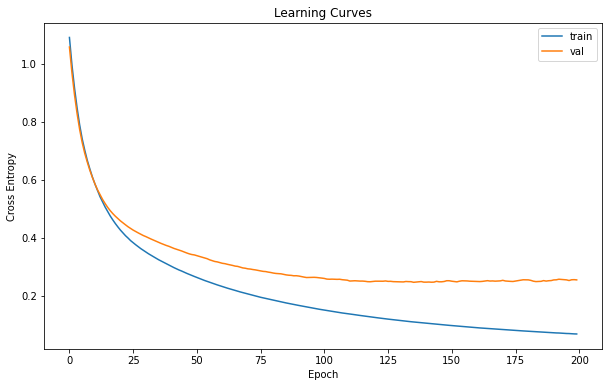

In [62]:
# plot learning curves
plt.rcParams['figure.figsize'] = [10, 6]
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

We can see that the model appears to converge but has overfit the training dataset.

Let’s try increasing the capacity of the model. This will slow down learning for the same learning hyperparameters and may offer better accuracy. We will add a second hidden layer with eight nodes, chosen arbitrarily.

In [80]:
def get_mlp_model2(n_features=X_train.shape[1], hidden_layers=[10, 8], dropout_layers=None):    
    # define model
    model = Sequential()
    for i, hidden_layer_size in enumerate(hidden_layers):
        if i == 0:
            model.add(Dense(hidden_layer_size, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
        else:
            model.add(Dense(hidden_layer_size, activation='relu', kernel_initializer='he_normal'))
            
        if dropout_layers:
            model.add(Dropout(dropout_layers[i]))
            
    model.add(Dense(1, activation='sigmoid'))

    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return model

In [72]:
model = get_mlp_model2(X_train.shape[1])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                350       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 447
Trainable params: 447
Non-trainable params: 0
_________________________________________________________________


In [67]:
# fit the model
history = model.fit(
    X_train, 
    y_train, 
    epochs=200,
    batch_size=32,
    verbose=0,
    validation_data=(X_test,y_test)
)

In [68]:
# predict test set
yhat = model.predict(X_test)

y_predict = yhat > 0.5
y_predict = y_predict.astype(int)

In [69]:
# evaluate predictions
score = accuracy_score(y_test, y_predict)
print('Accuracy: %.3f' % score)

Accuracy: 0.914


In this case, the model achieves a better accuracy score, with a value of about 91.4 percent. We will ignore model performance for now. Let's draw the learning curve to see if there is any overfitting happen:

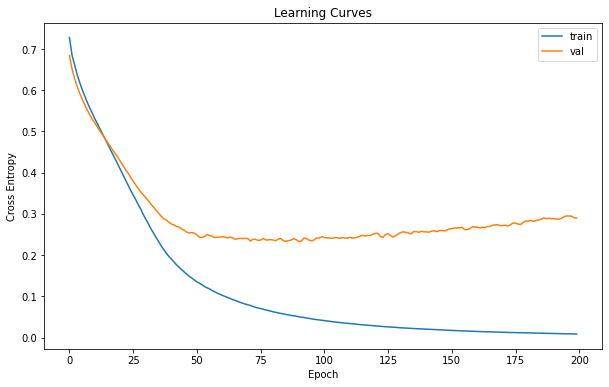

In [70]:
# plot learning curves
plt.rcParams['figure.figsize'] = [10, 6]
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

Now that we have some idea of the learning dynamics for simple MLP models on the dataset, we can look at evaluating the performance of the models as well as tuning the configuration of the models. (<font color='brown'>`val loss` is slightly increased after epoch 125 which is a sign of overfitting...</font>)

<a id='sect3'></a>
## <font color='darkblue'>Evaluating and Tuning MLP Models</font>
**The k-fold cross-validation procedure can provide a more reliable estimate of MLP performance, although it can be very slow.**

This is because k models must be fit and evaluated. This is not a problem when the dataset size is small, such as the ionosphere dataset. We can use the [**StratifiedKFold**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) class and enumerate each fold manually, fit the model, evaluate it, and then report the mean of the evaluation scores at the end of the procedure. For example:
```python
kfold = KFold(10)
# enumerate splits
scores = list()
for train_ix, test_ix in kfold.split(X, y):
	# fit and evaluate the model...
	...
...
# summarize all scores
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))
```

We can use this framework to develop a reliable estimate of MLP model performance with a range of different data preparations, model architectures, and learning configurations.

**It is important that we first developed an understanding of the learning dynamics of the model on the dataset in the previous section before using k-fold cross-validation to estimate the performance**. If we started to tune the model directly, we might get good results, but if not, we might have no idea of why, e.g. that the model was over or under fitting.

If we make large changes to the model again, it is a good idea to go back and confirm that the model is converging appropriately. Now check code below:

In [82]:
def train_model_with_perf_eval(k=10, hidden_layers=[50, 10], dropout_layers=None):
    # prepare cross validation
    kfold = StratifiedKFold(10)

    # enumerate splits
    scores = list()
    for train_ix, test_ix in kfold.split(X, y):
        # split data    
        X_train, X_test, y_train, y_test = X[train_ix], X[test_ix], y[train_ix], y[test_ix]
    
        # determine the number of input features
        n_features = X.shape[1]

        # define model
        model = get_mlp_model2(hidden_layers=hidden_layers, dropout_layers=dropout_layers)
    
        # fit the model
        model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

        # predict test set
        yhat = model.predict_classes(X_test)
        y_predict = (yhat > 0.5).astype(int)

        # evaluate predictions
        score = accuracy_score(y_test, y_predict)
        print('>%.3f' % score)
        scores.append(score)
    
    # summarize all scores
    print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

In [83]:
train_model_with_perf_eval()

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


>0.944
>0.943
>0.971
>0.914
>0.857
>0.914
>0.943
>0.971
>0.971
>0.914
Mean Accuracy: 0.934 (0.034)


We will use this result as our baseline to see if we can achieve better performance (So far, our mean accuracy=93.4 percent).

Next, let’s try adding regularization to reduce overfitting of the model. In this case, we can add dropout layers between the hidden layers of the network. Let's see how it impact our performance this time:

In [86]:
train_model_with_perf_eval(dropout_layers=[0.2, 0.2])

c:\users\john\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


>0.972
>0.943
>0.943
>0.914
>0.971
>0.886
>1.000
>1.000
>0.971
>0.914
Mean Accuracy: 0.952 (0.036)


In this case, we can see that the **MLP model with dropout achieves slightly better results with an accuracy of about 95.2 percent.**

We could continue to test alternate configurations to the model architecture (<font color='brown'>more or fewer nodes or layers</font>), learning hyperparameters (<font color='brown'>more or fewer batches</font>), and data transforms. Next, let’s look at how we might fit a final model and use it to make predictions.

<a id='sect4'></a>
## <font color='darkblue'>Final Model and Make Predictions</font>
**Once we choose a model configuration, we can train a final model on all available data and use it to make predictions on new data.**

In this case, we will use the model with dropout and a small batch size as our final model. We can prepare the data and fit the model as before, although on the entire dataset instead of a training subset of the dataset.

In [87]:
# Final model
model = get_mlp_model2(hidden_layers=[50, 10], dropout_layers=[0.2, 0.2])

# Fit the model with whole dataset
model.fit(X, y, epochs=200, batch_size=32, verbose=0)

First, we can define a row of new data:<br/>
<font color='darkred'>**Note**</font>: I took this row from the first row of the dataset and the expected label is a ‘1‘.

In [100]:
# define a row of new data
# row = [1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300]
row = X[0].tolist()
expected_label = y[0]

We can then make a prediction.

In [102]:
# make prediction
yhat = model.predict_classes([row])

# invert transform to get label for class
yhat = le.inverse_transform(yhat)

# report prediction
print(f'Predicted: {yhat[0]} (expected {expected_label})')

Predicted: 1 (expected 1)
